In [4]:
# pip 설치 목록(설치일 : 2023-12-11)

# GPU 사용시
# python 3.10.13 - GPU 사용 용도 다운그레이드
# tensorflow==2.10.0
# tensorflow-gpu==2.10.0

#CPU 사용시
# tensorflow

# 공통
# ipykernel     #디버깅 실행용
# opencv-python #cv2가 얘임
# pillow        #없으면 학습 때 에러남
# scipy         #없으면 학습 때 에러남

# matplotlib    #학습그래프 보는용도
# pydot         #학습 그래프 보는용도
# joblib        #저장하는용도
# torch


In [5]:
import tensorflow as tf         #DL 기본
import os                       #연동 CPU,GPU 변경, 파일 이동
import tkinter as tk            #Python일 떄 폴더 선택 Window
from tkinter import filedialog  #Python일 떄 폴더 선택 Window
import shutil                   #파일 이동
import cv2                      #OpenCV
import numpy as np              #Array 사용용도
import glob                     #파일 리스트 확인
import shutil                   #파일 이동
import matplotlib.pyplot as plt #학습 결과 확인 그래프
import datetime                 #저장 시 날짜

In [6]:

print(tf.__version__)
if(tf.__version__ == '2.10.0'):
    print('GPU Set')
    # GPU 학습시키기 Log
    # https://velog.io/@haikoo_ai96/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-gpu-%EC%84%A4%EC%A0%95-reeqenho 여기 사이트 설명 잘한듯?
    # '장치 관리자' - '디스플레이 어댑터'에 사용하는 그래픽카드 모델명 확인
    # https://www.tensorflow.org/install/source_windows?hl=ko 사이트의 CUDA-Enabled에서 자기의 그래픽 카드에따른 Compute Capability 확인 - 내꺼는 6.1
    # https://en.wikipedia.org/wiki/CUDA의 GPU Supported 항목의 'Compute Capability (CUDA SDK support vs. Microarchitecture)'그림에서 Pascal부분이 자신의 Compute Capability로 생각하여 지원 가능한 CUDA SDK 버전 확인

    # GTX1060 compute capability = 6.1 -> CUDA 8.0 ~ 12.3연동 가능
    # window 에서는 tensorflow_gpu 2.10 이하만 사용 가능
    # tensorflow_gpu 2.10 - CUDA 11.2 사용 가능
    #                       cuDNN 8.1 사용 가능
    #                       Python 3.7~3.10 사용 가능

    # ! nvidia-smi
    # 우측 상단의 CUDA Version 확인
    # https://developer.nvidia.com/cuda-toolkit-archive 사이트에서 자기 버전에 맞는 'CUDA Toolkit 버전' 클릭하여 설치
    # Max Ver. 11.2
    # CUDA 11.2.2의 설치 버전이 Windows10까지밖에 없음, 현재 내컴이 11이기때문에 안될 수도 있음

    # https://developer.nvidia.com/rdp/cudnn-download 사이트에서 가입 후 'cuDNN'을 위 CUDA 버전에 맞게 다운
    # C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\'버전' 에 해당 압축파일 덮어쓰기

    from tensorflow.python.client import device_lib
    device_lib.list_local_devices()
    # # 출력 후 아래 'device_type :'에 GPU가 존재하는지 확인
    # # 있으면 연동은 확인된 거 연결은 아직

    print(tf.test.is_built_with_cuda()) #CUDA 작동 확인
    print(tf.test.is_built_with_gpu_support())  #GPU Support 확인

    imsi = tf.config.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(imsi, True) #메모리증가 활성화
    tf.config.experimental.set_virtual_device_configuration(imsi, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    #근데 메모리 부족으로 못씀.... 여러개 병렬 해야하나?
else:
    print('CPU Set')
    
    boolGPU = tf.config.list_physical_devices('GPU')
    print('GPU List', boolGPU)
    if(len(boolGPU) > 0):
        #GPU 잡혀있을때 안쓰고 CPU만으로 쓰게 만들기
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2.15.0
CPU Set
GPU List []


In [7]:
#파일 호출
# Python 기본 윈도우 숨기기, jupyter에서 작동 안됨
# root = tk.Tk()
# root.withdraw() 
# openFilePath = filedialog.askdirectory(
#     # filetypes=(("xlsx File", "*.xlsx"), ("xls File", "*.xls")),
#     title='적용파일 불러오기'
# )
openFolderPath = 'E:\\00.Storage\\Study\\Programing\\Project\\Img_Process\\Image_List'

In [8]:
#구분용 폴더 만들기
#ReSize한 폴더 삭제 후 생성
resizeFolderName = os.getcwd() + '\\Train'
if os.path.exists(resizeFolderName):
    shutil.rmtree(resizeFolderName)
os.mkdir(resizeFolderName)


#ReSzie한 폴더에 하위 폴더 삭제 후 생성
for labelName in os.listdir(openFolderPath):
    if(labelName == 'pass') : continue #pass 폴더일 경우 스킵
    labelFolder = resizeFolderName + '\\' + labelName

    #폴더 리스트 경로에 파일 있으면 해당 파일면으로 폴더생성됨(내 폴더 기준으로 os.path.isdir 써도 안먹힘)
    if os.path.exists(labelFolder):
        shutil.rmtree(labelFolder)
    os.mkdir(labelFolder)


testFolderName = os.getcwd() + '\\Test'
if os.path.exists(testFolderName):
    shutil.rmtree(testFolderName)
os.mkdir(testFolderName)

#Test 폴더에 하위 폴더 삭제 후 생성
for labelName in os.listdir(openFolderPath):
    if(labelName == 'pass') : continue #pass 폴더일 경우 스킵
    
    labelFolder = testFolderName + '\\' + labelName

    #폴더 리스트 경로에 파일 있으면 해당 파일면으로 폴더생성됨(내 폴더 기준으로 os.path.isdir 써도 안먹힘)
    if os.path.exists(labelFolder):
        shutil.rmtree(labelFolder)
    os.mkdir(labelFolder)

In [9]:
#이미지 사이즈 수정하기

#파일 사이즈 설정 및 수정본 저장
for labelName in os.listdir(openFolderPath):
    if(labelName == 'pass') : continue #pass 폴더일 경우 스킵
    
    labelFile = openFolderPath + '\\' + labelName
    savePath = resizeFolderName + '\\'  + labelName

    print('Focused Folder : ', labelFile)
    print('Saving Folder : ', savePath)

    for fileName in os.listdir(labelFile):
        filePath = labelFile + '\\' + fileName

        #이미지 크기 변경
        img = cv2.imread(filePath, cv2.IMREAD_COLOR) #이미지 가져오기

        if (type(img) == np.ndarray) : #꺠진파일 거르기
            if (str(img.shape) != '(1000, 1000, 3)') : 
                print('BfSize :', img.shape)
                img = cv2.resize(img, dsize=(1000,1000), interpolation=cv2.INTER_AREA)
                print('AfSize :', img.shape)
                print('ReSize Image :', fileName)

            #이미지 저장
            cv2.imwrite(savePath + '\\' + fileName, img)
            print('Saved Image :', fileName)

Focused Folder :  E:\00.Storage\Study\Programing\Project\Img_Process\Image_List\border_down_title
Saving Folder :  e:\00.Storage\Study\Programing\Project\Img_Process\Train\border_down_title
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10205044.jpg
Saved Image : M01DG10205044.jpg
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10205049.jpg
Saved Image : M01DG10205049.jpg
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10205187.jpg
Saved Image : M01DG10205187.jpg
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10236824.jpg
Saved Image : M01DG10236824.jpg
Saved Image : M01DG10238124.jpg
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10322424.jpg
Saved Image : M01DG10322424.jpg
Saved Image : M01DG10322442.jpg
Saved Image : M01DG10327397.jpg
Saved Image : M01DG10327399.jpg
Saved Image : M01DG10347629.jpg
BfSize : (600, 600, 3)
AfSize : (1000, 1000, 3)
ReSize Image : M01DG10375719.jpg
Save

In [10]:
#학습, 테스트 데이터 분할
extensions = ['jpg', 'png']
ratio = 0.1

#테스트파일 이동
for labelName in os.listdir(openFolderPath):
    if(labelName == 'pass') : continue #pass 폴더일 경우 스킵
    
    for extension in extensions:#이미지 확장자
        imgList = glob.glob(resizeFolderName + '\\' + labelName + '\\*.' + extension)

        #파일 이동
        for img in imgList[0:int(ratio*len(imgList))]:
            if not os.path.exists(testFolderName + '\\' + labelName):
                shutil.move(img, testFolderName + '\\' + labelName)
                # print('Moved Img from ReSize to Test : ', img)

        print('Move End .' + extension, '/ Cnt :', len(imgList))
    print('Move End', labelName, 'Label')

Move End .jpg / Cnt : 625
Move End .png / Cnt : 0
Move End border_down_title Label
Move End .jpg / Cnt : 112
Move End .png / Cnt : 0
Move End border_only Label
Move End .jpg / Cnt : 16
Move End .png / Cnt : 0
Move End border_upNdown_title Label
Move End .jpg / Cnt : 178
Move End .png / Cnt : 0
Move End border_up_title Label
Move End .jpg / Cnt : 512
Move End .png / Cnt : 0
Move End white_bg Label


In [11]:
#Generator 설정
from tensorflow.keras.preprocessing.image import ImageDataGenerator

imgMaxWidth = 1000
imgMaxHeight = 1000
rateValidation = 0.15

#DataGenerator 설정
#: Tensor 이미지 데이터 배치 생성
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  validation_split=rateValidation)
validationDataGen = ImageDataGenerator(rescale=1./255,
                                       validation_split = rateValidation)

#Generator 설정
#: Directory 경로를 사용하여 증강 데이터 배치를 생성
trainGen = trainDataGen.flow_from_directory(directory=resizeFolderName + '\\',
                                            batch_size=16,
                                            color_mode='rgb',
                                            class_mode='sparse',
                                            target_size=(imgMaxWidth, imgMaxHeight),
                                            subset='training')
validationGen = validationDataGen.flow_from_directory(directory=resizeFolderName + '\\',
                                                      batch_size=16,
                                                      color_mode='rgb',
                                                      class_mode='sparse',
                                                      target_size=(imgMaxWidth, imgMaxHeight),
                                                      subset='validation')

print(trainGen.class_indices)

Found 1230 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
{'border_down_title': 0, 'border_only': 1, 'border_upNdown_title': 2, 'border_up_title': 3, 'white_bg': 4}


In [12]:
#모델 만들기
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
#모델 구조 확인용
from tensorflow.keras.utils import plot_model





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 31, 31, 1024)      3228864   
 onal)                                                           
                                                                 
 Conv2D_Layer_1 (Conv2D)     (None, 31, 31, 32)        294944    
                                                                 
 Pooling_Layer_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 Conv2D_Layer_2 (Conv2D)     (None, 15, 15, 32)        9248      
                                                                 
 Pooling_Layer_2 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                      

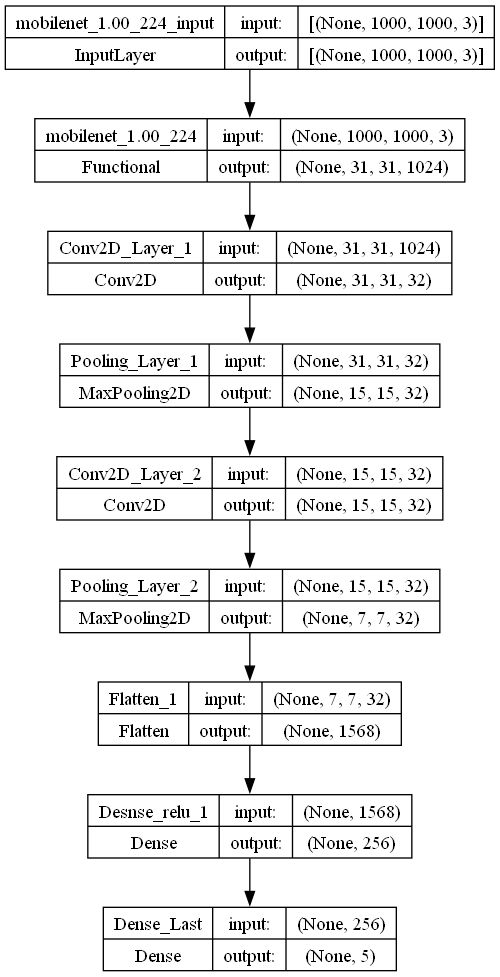

In [13]:
#Model 생성 실험 Log
#고정
baseModel = MobileNet(weights='imagenet',
                      include_top=False,
                      
                      input_shape=(imgMaxWidth, imgMaxHeight, 3))
#커스텀부
model = Sequential()
model.add(baseModel)

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding='SAME',
                 name='Conv2D_Layer_1'))
model.add(MaxPooling2D(strides=(2,2),
                       name='Pooling_Layer_1'))


model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding='SAME',
                 name='Conv2D_Layer_2'))
model.add(MaxPooling2D(strides=(2,2),
                       name='Pooling_Layer_2'))


#3차원 -> 1차원 변경
model.add(Flatten(name='Flatten_1'))

model.add(Dense(2 ** 8, activation='relu', name='Desnse_relu_1'))


#고정
model.add(Dense(int(len(trainGen.class_indices)), activation='softmax', name='Dense_Last'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5),
              metrics=['accuracy'])


model.summary()
plot_model(model, show_shapes=True)


In [14]:
#Model 학습
# accuracy : 훈련 정확도
# val_accuracy : Test파일 적용 정확도

# earlystopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(trainGen,
                 validation_data=validationGen,
                 epochs=1)
                #  callbacks=[earlystopping])
    



77/77 [==============================] - 1914s 25s/step - loss: 1.5016 - accuracy: 0.5683 - val_loss: 1.1123 - val_accuracy: 0.6056


In [15]:
#모델 저장
pathModel = os.getcwd() + '//Models'
if not os.path.exists(pathModel): #모델폴더 생성
    print('Not Exists LabelFolder, Create Folder : Models')
    os.mkdir(pathModel)
modelName = str(datetime.datetime.now().strftime('%Y%m%d_%H%M'))

model.save(pathModel + "\\" + modelName)

# import joblib


# #모델명 : 날짜_시분
# joblib.dump(model, pathModel + "\\" + modelName + ".pkl")

INFO:tensorflow:Assets written to: e:\00.Storage\Study\Programing\Project\Img_Process//Models\20240108_1143\assets


INFO:tensorflow:Assets written to: e:\00.Storage\Study\Programing\Project\Img_Process//Models\20240108_1143\assets


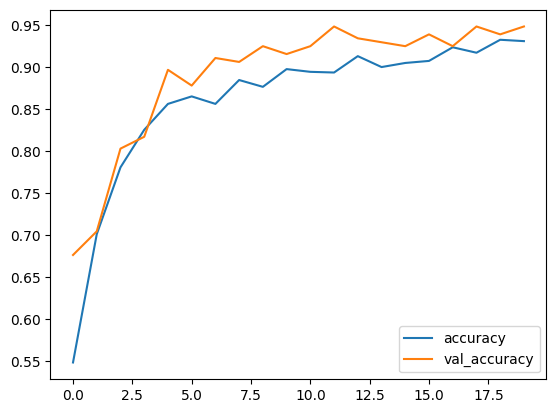

In [1]:
#학습결과보기
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# #테스트 구역
# import joblib
# import os

# path = os.getcwd() + '//Models'
# files = os.listdir(path)

# fileName = files[len(files) - 1]

# model = joblib.load(path + "\\" + fileName)

In [ ]:
len(trainGen.class_indices)

# print(int(model.output_shape[1]))
# print(int(len(os.listdir(openFolderPath))))

5